### Automatic watermark removal
This is the Jupyter notebook for automatic watermark removal code.
We follow the scripts till watermark estimation and then try to solve the watermarking problem.

In [2]:
%matplotlib inline
from src import *

gx, gy, gxlist, gylist = estimate_watermark('fine_timepieces')

est = poisson_reconstruct(gx, gy)
cropped_gx, cropped_gy = crop_watermark(gx, gy)
est2 = poisson_reconstruct(cropped_gx, cropped_gy)

# random photo
img = cv2.imread('fine_timepieces/1468889.jpg')
im, start, end = watermark_detector(img, cropped_gx, cropped_gy)

# plt.imshow(im)
# plt.show()

Computing gradients.
Computing median gradients.


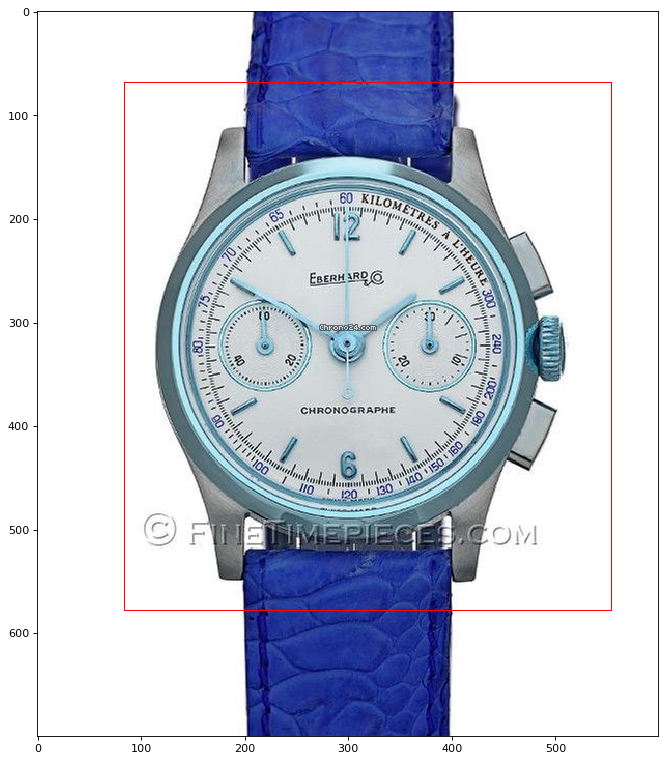

In [3]:
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(im)

In [4]:
print(cropped_gx.shape, cropped_gy.shape, est.shape, est2.shape)
print(im.shape, start, end)

(509, 470, 3) (509, 470, 3) (700, 600, 3) (509, 470, 3)
(700, 600, 3) (69, 84) (509, 470)


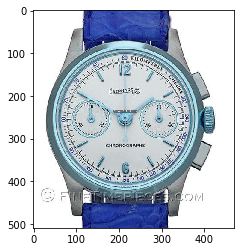

In [5]:
plt.imshow(img[start[0]:(start[0]+end[0]), start[1]:(start[1]+end[1]), :])

In [8]:
'''
This is the part where we get all the images, extract their parts, and then add it to our matrix
'''
num_images = len(gxlist)
images_cropped = np.zeros((num_images,) + cropped_gx.shape)

# get images
foldername = 'fine_timepieces'

# Store all the watermarked images
# start, and end are already stored
# just crop and store image
image_paths = []
_s, _e = start, end
index = 0

# Iterate over all images
for r, dirs, files in os.walk(foldername):

    for file in files:
        _img = cv2.imread(os.sep.join([r, file]))
        if _img is not None:
            # estimate the watermark part
            image_paths.append(os.sep.join([r, file]))
            _img = _img[_s[0]:(_s[0]+_e[0]), _s[1]:(_s[1]+_e[1]), :]
            # add to list images
            images_cropped[index, :, :, :] = _img
            index+=1
        else:
            print("%s not found."%(file))

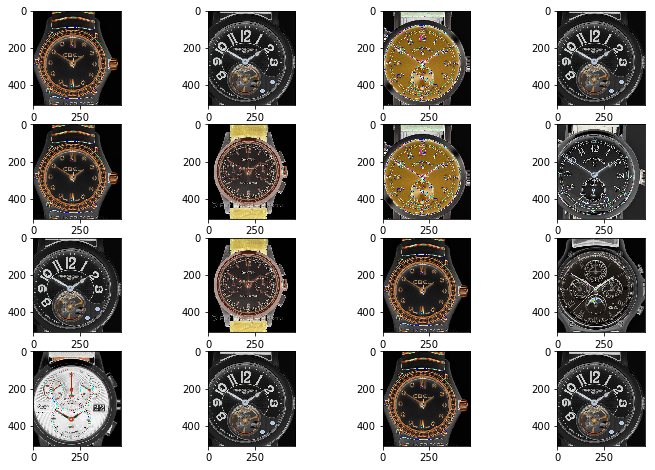

In [11]:
# Print some random indices extracted
N = 4
random_indices = np.random.randint(index, size=(N*N,))
fig, axes = plt.subplots(N, N, figsize=(12, 8))
for i, val in enumerate(random_indices):
    axes[i//N, i%N].imshow((images_cropped[val] * 255).astype(np.uint8))

### Image reconstruction
Here comes the tougher part. We have an initial estimate for the watermark `Wm, cropped_gx, cropped_gy` and `est`. Using this, we solve the problem of Multi-image matting and reconstruction. We have a list of images, `images_cropped`, and we have to estimate `W` and `alpha` by reiterating the following 3 steps: 
- Image-Watermark detection
- Watermark update
- Matte update

Finally, we do a Matte and blend factor initialization to determine the constant and normalized matte.

In [12]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
# helpers that are going to be useful here
sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], tf.float32)
sobel_y = tf.transpose(sobel_x)

sobel_x_filter = tf.stack([sobel_x, sobel_x, sobel_x])
sobel_x_filter = tf.stack([sobel_x_filter, sobel_x_filter, sobel_x_filter])

sobel_y_filter = tf.stack([sobel_y, sobel_y, sobel_y])
sobel_y_filter = tf.stack([sobel_y_filter, sobel_y_filter, sobel_y_filter])

def phi_func(mtensor, epsilon=0.001):
    return tf.sqrt(mtensor + epsilon**2)
    
# E_data
def E_data(I, W, J, alpha):
    est_error = tf.multiply(alpha, W) + tf.multiply(1-alpha, I) - J
    est_error = phi_func(tf.square(est_error))
    est_error = tf.reduce_sum(est_error)
    return est_error

# regularizer term for I, W
def E_reg(I, alpha):
    alpha_ = tf.expand_dims(alpha, 0)
    ax = tf.nn.conv2d(alpha_, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME")
    ay = tf.nn.conv2d(alpha_, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME")
    Ix2 = tf.square(tf.nn.conv2d(I, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME"))
    Iy2 = tf.square(tf.nn.conv2d(I, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME"))
    est_error = tf.multiply(tf.abs(ax), Ix2) + tf.multiply(tf.abs(ay), Iy2)
    est_error = tf.reduce_sum(phi_func(est_error))
    return est_error

# regularization term for alpha
def E_reg_alpha(alpha):
    alpha_ = tf.expand_dims(alpha, 0)
    ax2 = tf.square(tf.nn.conv2d(alpha_, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME"))
    ay2 = tf.square(tf.nn.conv2d(alpha_, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME"))
    est_error = tf.reduce_sum(phi_func(ax2 + ay2))
    return est_error

# fidelity term
# W = all watermarks
def E_f(alpha, W, W_m):
    aW = tf.multiply(alpha, W)
    # find edge map of alpha*W
    aWx = tf.nn.conv2d(aW, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME")
    aWy = tf.nn.conv2d(aW, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME")
    aW_ = tf.sqrt(tf.square(aWx) + tf.square(aWy))
    
    # find edge map of W_m
    W_m__ = tf.expand_dims(W_m, 0)
    W_mx = tf.nn.conv2d(W_m__, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME")
    W_my = tf.nn.conv2d(W_m__, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME")
    W_m_ = tf.sqrt(tf.square(W_mx) + tf.square(W_my))
    
    return tf.reduce_sum(phi_func(tf.square(aW_ - W_m_)))

# auxiliary term
def E_aux(W, W_k):
    return tf.reduce_sum(tf.abs(W - W_k))


# We try to use Tensorflow to perform the 3 steps
def image_watermark_decompose_model(num_images, m, n, chan=3, l_i=1, l_w=1, l_alpha=1, beta=1, gamma=1):
    # We have the following parameters
    # num_images = number of images, m, n, number of channels
    # lambda_i, lambda_w, lambda_alpha, beta, and gamma are parameters
    # Input to network: 
    #    J(k) = (num_images, m, n, chan) -> all the images
    #    W_m = (m, n, chan)   -> estimate of the watermark obtained before
    #    W_median =   (m, n, chan)   -> new estimate of W
    #    alpha = (m, n, chan) -> estimate of alpha matte
    # Entities to estimate
    #    I(k) = (num_images, m, n, chan) -> all watermarked images
    #    W(k) = (num_images, m, n, chan) -> all watermarks
    
    # All placeholders
    J = tf.placeholder(tf.float32, shape=(num_images, m, n, chan), name='J')
    alpha = tf.placeholder(tf.float32, shape=(m, n, chan), name='alpha')
    W_m = tf.placeholder(tf.float32, shape=(m, n, chan), name='W_m')
    W_median = tf.placeholder(tf.float32, shape=(m, n, chan), name='W_median')
    
    # All variables
    I = tf.Variable(np.random.randn(num_images, m, n, chan), name='I', dtype=tf.float32)
    W = tf.Variable(np.random.randn(num_images, m, n, chan), name='W', dtype=tf.float32)
    
    # compute loss
    loss = E_data(I, W, J, alpha) + l_i*E_reg(I, alpha) + l_w*E_reg(W, alpha) \
            + beta*E_f(alpha, W, W_m) + gamma*E_aux(W_median, W)
    
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    return {
        'J': J,
        'alpha': alpha,
        'W_m': W_m,
        'W_median': W_median, 
        'I': I,
        'W': W,
        'loss': loss,
        'step': optimizer,
    }
    
    

In [14]:
num_images, m, n, chan = images_cropped.shape
model = image_watermark_decompose_model(num_images, m, n, chan)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Start 0
Start 1
Start 2
Start 3
Start 4
Start 5
Start 6
Start 7
Start 8
Start 9
Start 10
Start 11
Start 12
Start 13
Start 14
Start 15
Start 16
Start 17
Start 18
Start 19
Start 20
Start 21
Start 22
Start 23
Start 24
Start 25
Start 26
Start 27
Start 28
Start 29
Start 30
Start 31
Start 32
Start 33
Start 34
Start 35
Start 36
Start 37
Start 38
Start 39
Start 40
Start 41
Start 42
Start 43
Start 44
Start 45
Start 46
Start 47
Start 48
Start 49
Start 50
Start 51
Start 52
Start 53
Start 54
Start 55
Start 56
Start 57
Start 58
Start 59
Start 60
Start 61
Start 62
Start 63
Start 64
Start 65
Start 66
Start 67
Start 68
Start 69
Start 70
Start 71
Start 72
Start 73
Start 74
Start 75
Start 76
Start 77
Start 78
Start 79
Start 80
Start 81
Start 82
Start 83
Start 84
Start 85
Start 86
Start 87
Start 88
Start 89
Start 90
Start 91
Start 92
Start 93
Start 94
Start 95
Start 96
Start 97
Start 98
Start 99


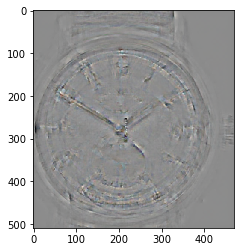

In [15]:
# define the variables
# plt.imshow(PlotImage(est2))
W_m = est2
J = images_cropped
I = np.random.randn(num_images, m, n, chan)
alpha = np.random.rand(m, n, chan)
W_median = W_m.copy()
W = np.stack([W_m for _ in range(num_images)])
print
saver = tf.train.Saver()
with tf.Session() as sess:
    init_op = tf.initialize_all_variables()

    sess = tf.Session()
    sess.run(init_op)
    for i in range(100):
        print("Start",i)
        _, loss = sess.run([model['step'], model['loss']], feed_dict={
            model['J']: J,
            model['alpha']: alpha,
            model['W_m']: W_m,
            model['W_median']: W_median,
        })
        plt.imshow(PlotImage(W_m))
    
